# Model Calibration
## Why calibrate?
Calibration is the process of fine-tuning an agent-based model's input parameters so that its simulated outputs align with real-world data. Without calibration, the model might generate plausible-looking behavior that doesn’t actually reflect reality. Calibration improves the model’s credibility, predictive power, and policy relevance by ensuring it reproduces key observed patterns or outcomes from historical data.

## Calibration Process Overview
1. Define Calibration Targets:
Select measurable real-world data points (e.g., population size, disease prevalence, contraceptive use) that the model should replicate.

2. Identify Parameters to Tune:
Choose uncertain model parameters that strongly influence the outcomes but lack precise empirical estimates (e.g., agent behavior probabilities, environmental factors, etc.).

3. Choose a Calibration Method:
Use either:
- Manual/heuristic tuning (trial-and-error or expert knowledge), or
- Automated optimization (e.g., grid search, random search, genetic algorithms, or Bayesian methods) to systematically explore parameter space.

4. Define a Goodness-of-Fit Metric:
Quantify how well the model output matches the targets using metrics like root mean squared error (RMSE), likelihood scores, or custom error functions.

5. Run the Calibration:
Simulate the model repeatedly with different parameter values and evaluate performance using the fit metric.

6. Select Best-Fit Parameters:
Identify parameter sets that produce model outputs closest to observed data.

7. Validate (if possible):
Use separate data not involved in calibration to assess the model’s generalizability.

In this tutorial, we will walk through the basics of running both a manual and automated calibration. Choosing between manual and automated calibration depends on the model complexity, parameter uncertainty, available data, and computational resources. 

## Manual Calibration
Manual calibration involves adjusting parameters by hand based on expert knowledge or visual inspection of outputs. This can make sense when:
- The model has few parameters to tune
- You have strong domain knowledge about parameter ranges
- You are in the early stages of model development or prototyping
- The simulation is computationally expensive or you have limited computational resources
- You want to explore model behavior qualitatively

The plotting class (in plotting.py) can be used to visually inspect the outputs of common target parameters (e.g. CPR, method mix, TFR, etc.) and compare the model output vs real-world data.

## Automated Calibration
Automated calibration uses optimization algorithms (like Optuna’s Bayesian optimization) to efficiently search parameter space for the best fit. An automated calibration in FPsim uses the calibration and experiment classes to use Optuna's optimization methods to determine the best free parameters. This makes sense to use when:
- Your model has many uncertain parameters (e.g. 5+)
- You have access to compute resources to run many simulations (e.g. in parallel on a machine or VM with ample processing power, memory, and storage OR on a cloud computing platform)
- You have a large number of target parameters to which you want to calibrate with an unbiased approach
 
A hybrid approach can also be to start with a manual calibration to narrow down plausible ranges and understand model dynamics. Then switch to automated methods to fine-tune parameters and formalize the process. 

## Preparing the data

In order to run a calibration successfully, we need to ensure that the fpsim/locations directory contains a directory for the country being calibrated (i.e. 'fpsim/locations/kenya'). This directory should also contain:
- A model file (i.e. fpsim/locations/kenya/kenya.py)
- A data subdirectory with data for the desired calibration targets (see fpsim/locations/README.md for specific files and means of generating each), ideally with the most recently available comprehensive data to compare with the model output 

Ensure that the data in the aforementioned files are formatted in the same manner as those in `locations/kenya/data`.

## Running a Manual Calibration
### Imports
First, we import any needed packages. We also import the plotting class, which is useful in visually inspecting the model vs observed data.

In [1]:
import sys
sys.path.insert(0, '/Users/')
sys.path.insert(0, '/Users/laurynbruce/')
sys.path.insert(0, '/Users/laurynbruce/')
sys.path.insert(0, '/Users/laurynbruce/Documents/')
sys.path.insert(0, '/Users/laurynbruce/Documents/Lauryn_Bruce/UCSD/')
sys.path.insert(0, '/Users/laurynbruce/Documents/Lauryn_Bruce/UCSD/research/')
sys.path.insert(0, '/Users/laurynbruce/Documents/Lauryn_Bruce/UCSD/research/Gates/')
sys.path.insert(0, '/Users/laurynbruce/Documents/Lauryn_Bruce/UCSD/research/Gates/project/')
sys.path.insert(0, '/Users/laurynbruce/Documents/Lauryn_Bruce/UCSD/research/Gates/project/fpsim/')
sys.path.insert(0, '/Users/laurynbruce/Documents/Lauryn_Bruce/UCSD/research/Gates/project/fpsim/fpsim/')

In [2]:
import fpsim as fp
from fpsim import plotting as plt
import numpy as np

### Setting Parameters

First, we set up our parameters for the simulation(s) used for calibration, including the country name and any specific sim params, such as the population size and start/end year of the sim.

In [3]:
country = 'nigeria_kano'
pars = fp.make_fp_pars()
pars.update_location(country)

Next we set our free parameters to initial values that we will iteratively tune to optimize the model outputs (to be as close as possible to real-world data). The free parameters below are used for tuning:
- fecundity_var_low, fecundity_var_high
- exposure_factor
- spacing_pref
- primary_infertility
- age-based exposure (modified in {country}.py)
- parity-based exposure (modified in {country}.py)

We can also modify the contraceptive choice parameters, which can be useful especially in adjusting the model contraceptive prevalence rate. The `prob_use_year` parameter is helpful to adjust the CPR starting point (seen in the CPR trend plot), and the `prob_use_trend_par` parameter is helpful to adjust the slope in the CPR trend plot. Lastly, the `method_weights` array parameter is useful in tuning the method mix, for example - increasing the % of pill use and decreasing the % of IUD use. 

## Lauryn's Attempt

In [4]:
# Initial free parameters for calibration
pars['fecundity_var_low'] = 1
pars['fecundity_var_high'] = 1
pars['exposure_factor'] = 1

# Postpartum sexual activity correction or 'birth spacing preference'. Pulls values from {location}/data/birth_spacing_pref.csv by default
# Set all to 1 to reset. Option to use 'optimize-space-prefs.py' script in this directory to determine values
# 'months': array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36., 39., 42., 45., 48., 51., 54.]), 
# pars['spacing_pref']['preference'][:3] =  1  # Spacing of 0-6 months
# pars['spacing_pref']['preference'][3:4] = 1  # Spacing of 9 months
# pars['spacing_pref']['preference'][4:8] = 0.8  # Spacing of 12-24 months
# pars['spacing_pref']['preference'][8:16] = 4  # Spacing of 24-48 months
# pars['spacing_pref']['preference'][16:] =  0.2  # Spacing of 48-56 months
pars['spacing_pref']['preference'][:3] =  1  # Spacing of 0-6 months
pars['spacing_pref']['preference'][3:6] = 1  # Spacing of 9-15 months
pars['spacing_pref']['preference'][6:9] = 1  # Spacing of 18-24 months
pars['spacing_pref']['preference'][9:] =  1  # Spacing of 27-36 months

# Adjust contraceptive choice parameters
cm_pars = dict(
    prob_use_year=2020,  # Time trend intercept
    prob_use_trend_par = 0.01,   # Time trend in contraceptive use
    prob_use_intercept = 0.4,  # Intercept for the probability of using contraception
    method_weights=np.array([0.2, 0.5, 6, 2, 0.7, 0.2, 1, 0.5, 1])  # Weights for the methods in method_list in methods.py (excluding 'none', so starting with 'pill' and ending in 'othmod').
)
method_choice = fp.SimpleChoice(pars=cm_pars, location=country)     # The contraceptive choice module used (see methods.py for more documentation). We can select RandomChoice, SimpleChoice, or StandardChoice (StandardChoice is selected by default).


# Probability of Use function intercept

Location not supplied: using parameters from Senegal
Initializing sim with 1000 agents
  Running 2000.0 ( 0/241) (0.00 s)  ———————————————————— 0%
  Running 2001.0 (12/241) (0.04 s)  •——————————————————— 5%
  Running 2002.0 (24/241) (0.09 s)  ••—————————————————— 10%
  Running 2003.0 (36/241) (0.14 s)  •••————————————————— 15%
  Running 2004.0 (48/241) (0.21 s)  ••••———————————————— 20%
  Running 2005.0 (60/241) (0.27 s)  •••••——————————————— 25%
  Running 2006.0 (72/241) (0.32 s)  ••••••—————————————— 30%
  Running 2007.0 (84/241) (0.37 s)  •••••••————————————— 35%
  Running 2008.0 (96/241) (0.42 s)  ••••••••———————————— 40%
  Running 2009.0 (108/241) (0.47 s)  •••••••••——————————— 45%
  Running 2010.0 (120/241) (0.53 s)  ••••••••••—————————— 50%
  Running 2011.0 (132/241) (0.58 s)  •••••••••••————————— 55%
  Running 2012.0 (144/241) (0.63 s)  ••••••••••••———————— 60%
  Running 2013.0 (156/241) (0.68 s)  •••••••••••••——————— 65%
  Running 2014.0 (168/241) (0.73 s)  ••••••••••••••—————

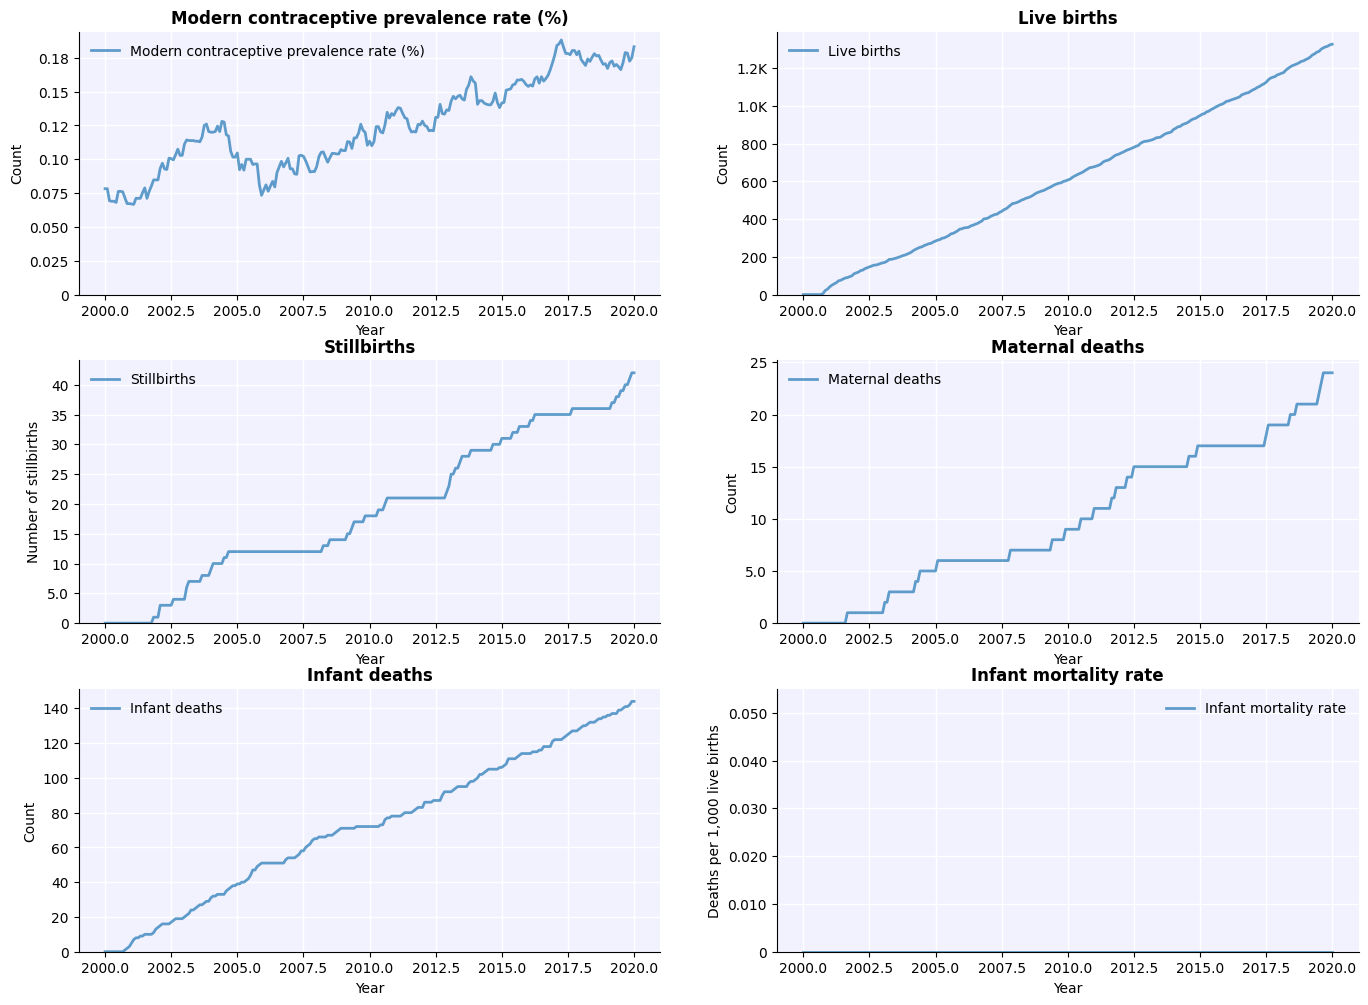

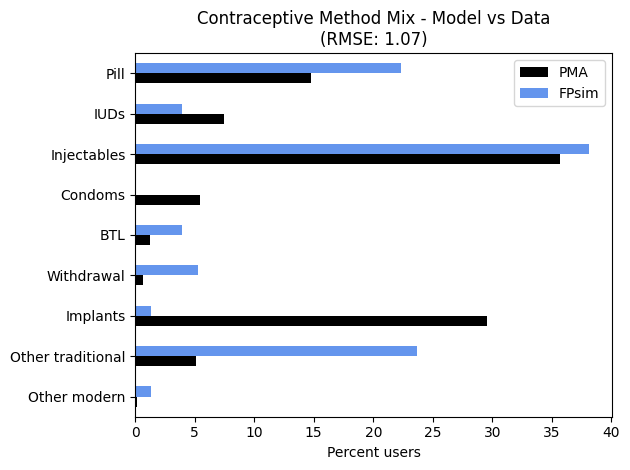

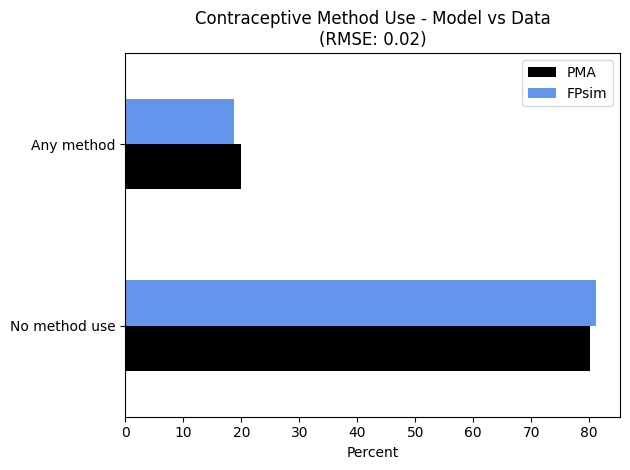

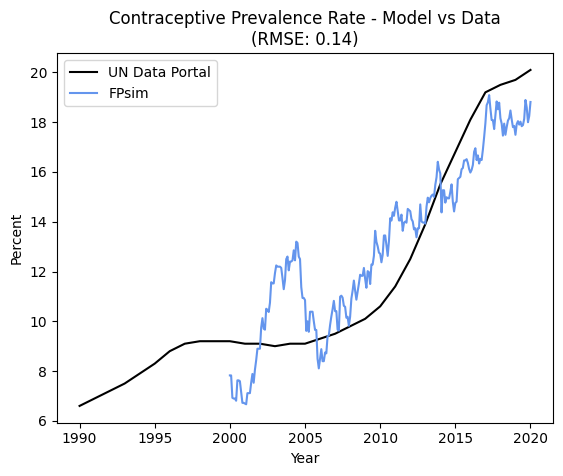

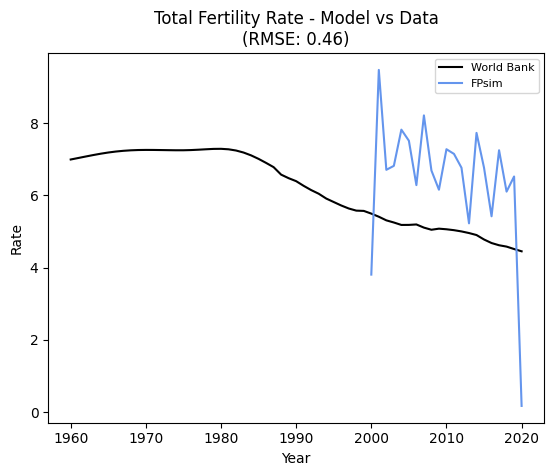

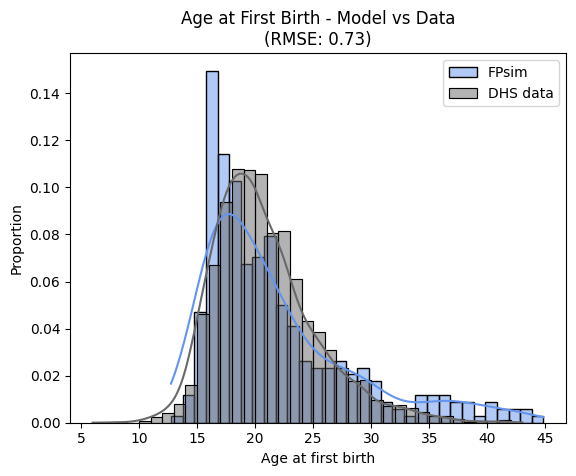

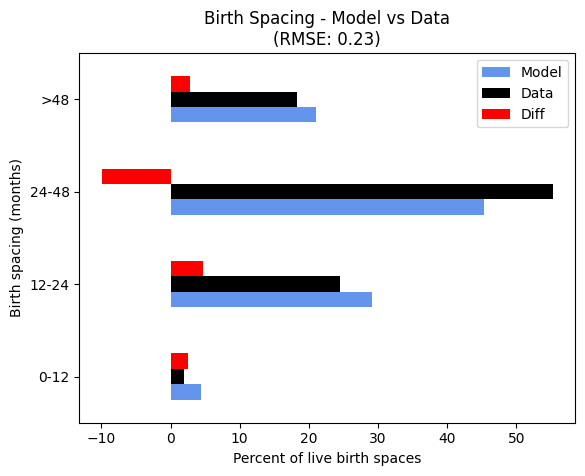

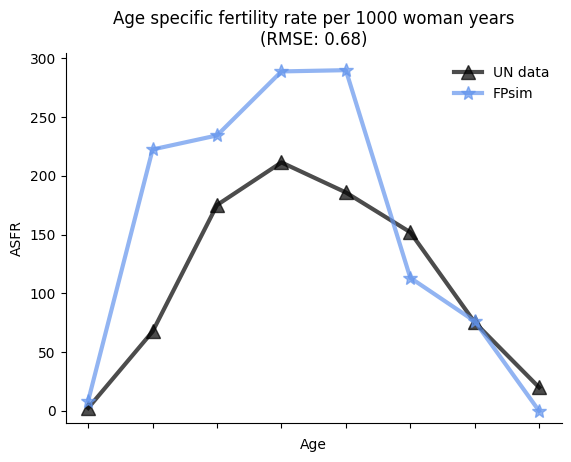

In [5]:
# Run the sim
sim = fp.Sim(pars=pars, contraception_module=method_choice)
sim.run()

# Plot sim
sim.plot()

# Plotting class function which plots the primary calibration targets (method mix, method use, cpr, total fertility rate, birth spacing, age at first birth, and age-specific fertility rate)
plt.plot_calib(sim)

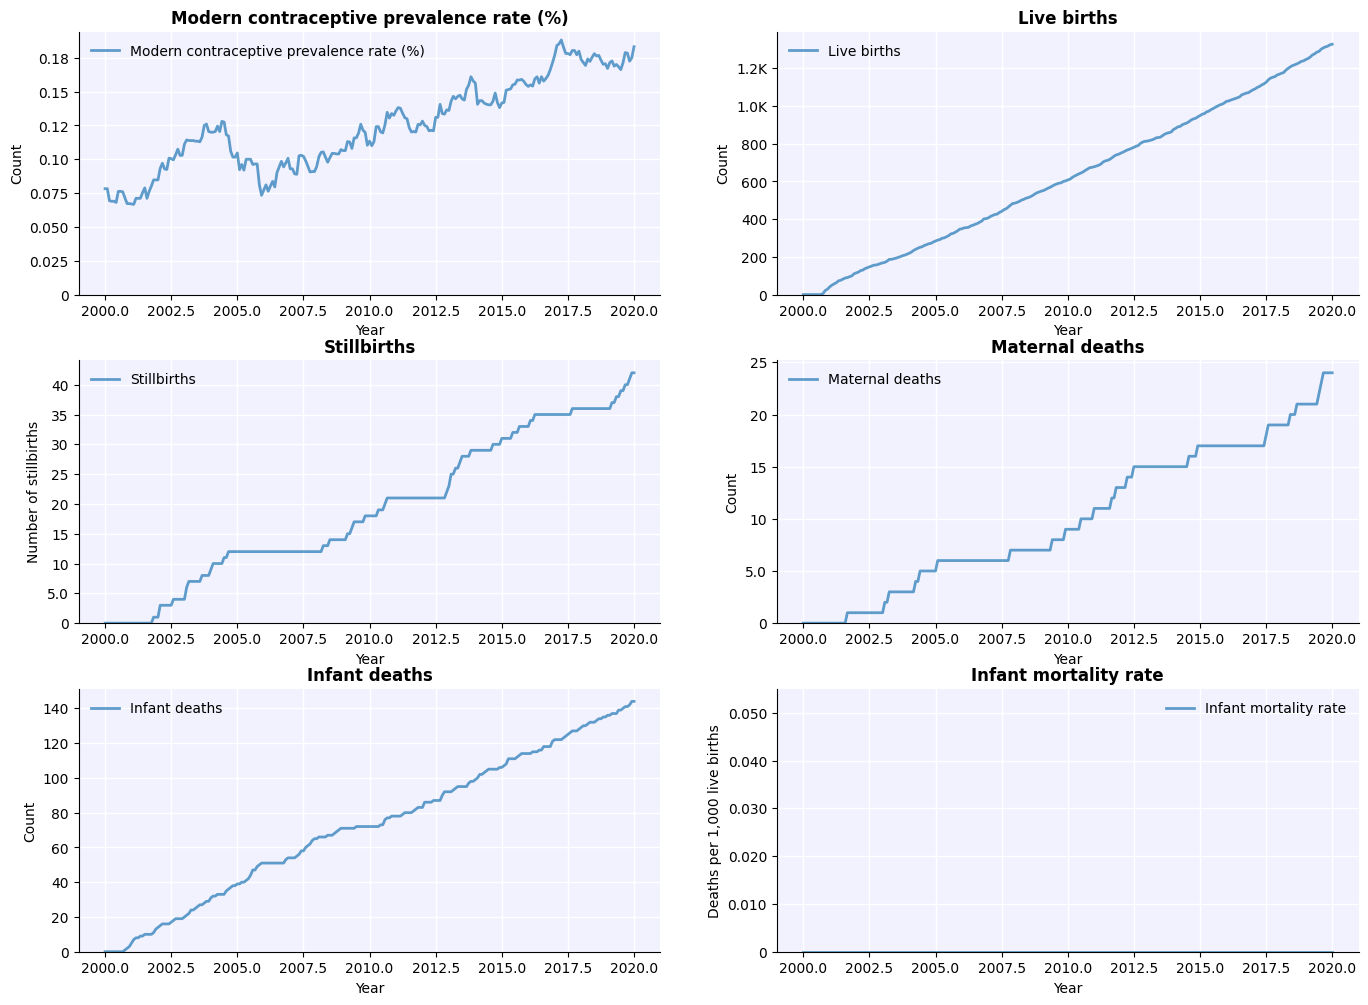

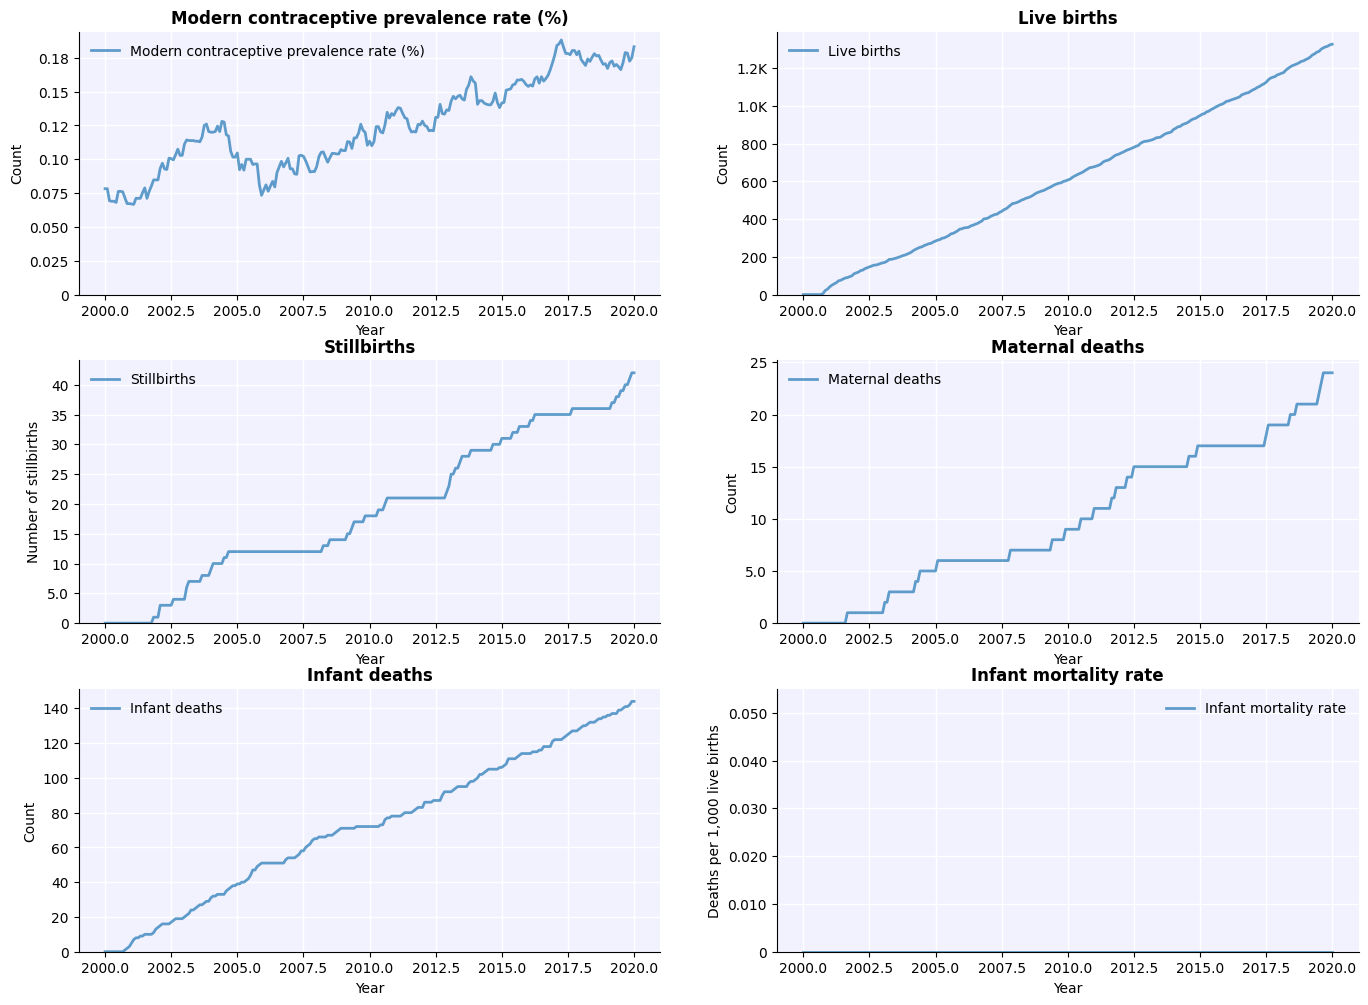

In [6]:
# Plot sim
sim.plot()